#### [https://functional-fusion.readthedocs.io/en/latest/08reliability.html](https://functional-fusion.readthedocs.io/en/latest/08reliability.html)

In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
from nilearn.mass_univariate import permuted_ols

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [9]:
dname = join(dir_git,'PcmPy')
sys.path.append(dname)
import PcmPy as pcm

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
mpl.rcParams['font.family'] = 'Helvetica'

---

In [12]:
glm = 1

In [13]:
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [14]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

---

In [15]:
list_sn = su.get_list_sn()

In [16]:
dir_group = join(dir_surf,'group')

---

In [17]:
dir_roi = su.get_dir_roi()

In [18]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [19]:
fname = join(dir_roi,'SPark2025.32k.L.label.gii')
gii = nb.load(fname)
mask = gii.darrays[0].data

In [20]:
list_roi = []
for ii, label in enumerate(gii.labeltable.labels):
    if ii>0:
        list_roi.append(label.label)
del gii
list_roi = np.array(list_roi)
list_roi

array(['S1', 'M1', 'SMA', 'PMd', 'PMv', 'SPLa', 'SPLp', 'IPS', 'V4d',
       'Vf', 'Vd', 'Vv', 'POS', 'TPOJ'], dtype='<U4')

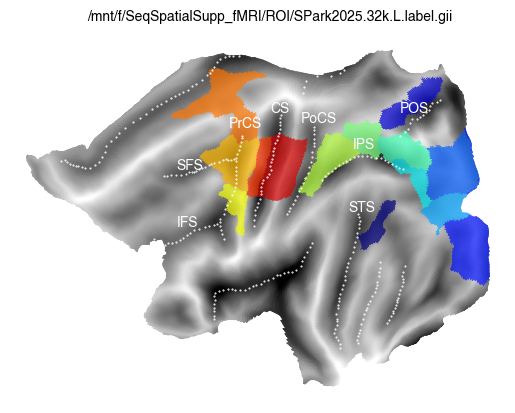

In [21]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet_r.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

In [22]:
def extract_data(data, mask, list_roi):
    result = {}
    for ii, roi in enumerate(list_roi):
        assert data.shape[-1] == mask.shape[0]
        val = ii+1
        idx = mask==val

        result[roi] = data[:,idx]

    return result

In [23]:
def extract_regvec(reginfo):
    list_ = ['(%d,%s)'%(s+1,c) for s in range(4) for c in ['L','S']]
    cond_vec = reginfo.name.replace({reg:'%d'%(i+1) for i,reg in enumerate(list_)}).astype(int).values
    part_vec = reginfo.run.values

    return cond_vec, part_vec

---

### Reliability within individual

In [24]:
lines = {'roi':[],'subj':[],'rw':[]}
for ss, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn
        
    reginfo = deal_spm.load_reginfo(subj=subj,dir_glm=dir_glm)
    
    cond_vec, part_vec = extract_regvec(reginfo)
    obs_des = {'cond_vec':cond_vec, 'part_vec':part_vec}
    
    fname = join(dir_surf,'glm_%1d'%glm,subj,'%s.%s.glm_%1d.beta.dscalar.nii'%(subj,hem,glm))
    cii = nb.load(fname)
    data = extract_data(data=cii.get_fdata(), mask=mask, list_roi=list_roi)
    for roi in list_roi:
        rw = rel.within_subj(
            data[roi],
            part_vec=part_vec, cond_vec=cond_vec,
            separate='none',
            subtract_mean=True
        )
        ## Leave-one-out reliability
        # rw = rel.within_subj_loo(
        #     data[roi],
        #     part_vec=part_vec, cond_vec=cond_vec,
        #     separate='none',
        #     subtract_mean=True
        # )
        lines['roi'].append(roi)
        lines['subj'].append(subj)
        lines['rw'].append(float(rw[0]))
df = pd.DataFrame(lines)

100%|███████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.19s/it]


In [25]:
df

,roi,subj,rw
0,S1,S01,0.038607
1,M1,S01,0.026811
2,SMA,S01,0.106861
3,PMd,S01,0.162189
4,PMv,S01,0.319879
...,...,...,...
163,Vf,S14,0.343966
164,Vd,S14,0.174726
165,Vv,S14,0.414321
166,POS,S14,0.032591


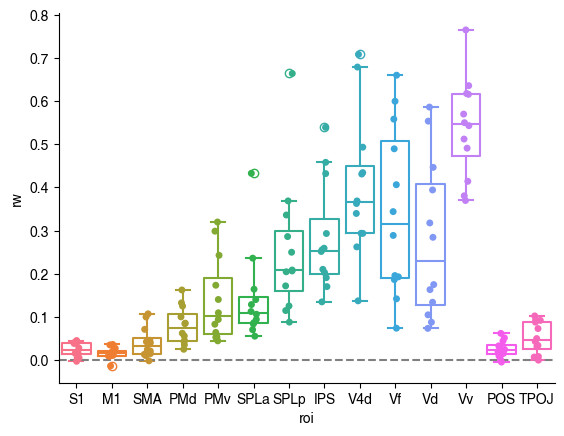

In [26]:
g = sns.boxplot(
    data=df,
    x='roi', y='rw',
    hue='roi', fill=False
)
g = sns.stripplot(
    data=df,
    x='roi', y='rw',
    hue='roi', jitter=True, size=5
)
g.axhline(y=0, linestyle='--', color='gray')
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

---

---